In [81]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from copy import deepcopy
import csv
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [82]:
batch_corrected_umap = sc.read('/scratch/batch_corrected_umap.h5ad')

# The UMAP

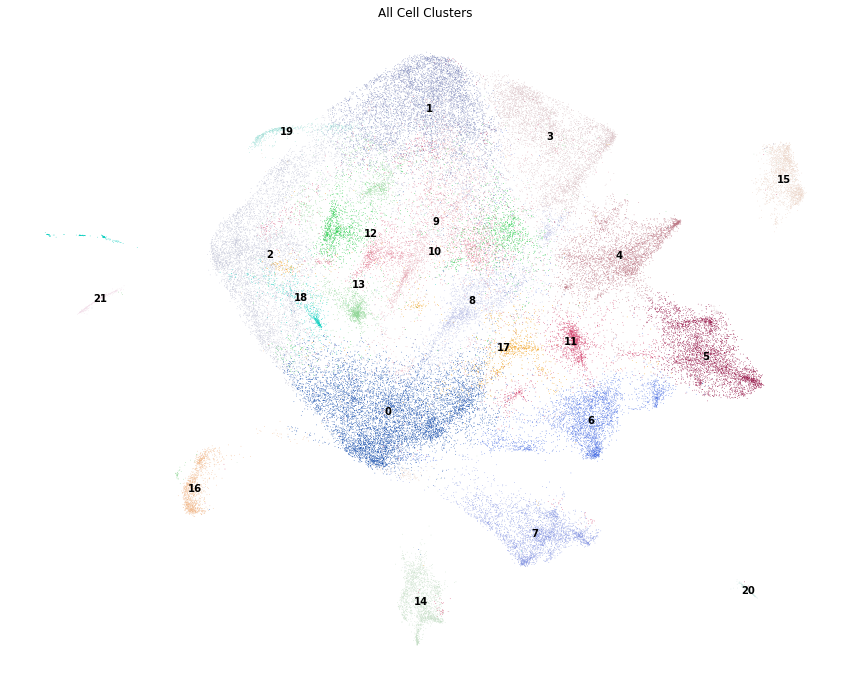

In [83]:
fig, ax = plt.subplots(figsize=(15,12))
sc.pl.umap(batch_corrected_umap, color='leiden', title='All Cell Clusters', legend_loc='on data',frameon=False,ax=ax)

### Differential expression on all genes

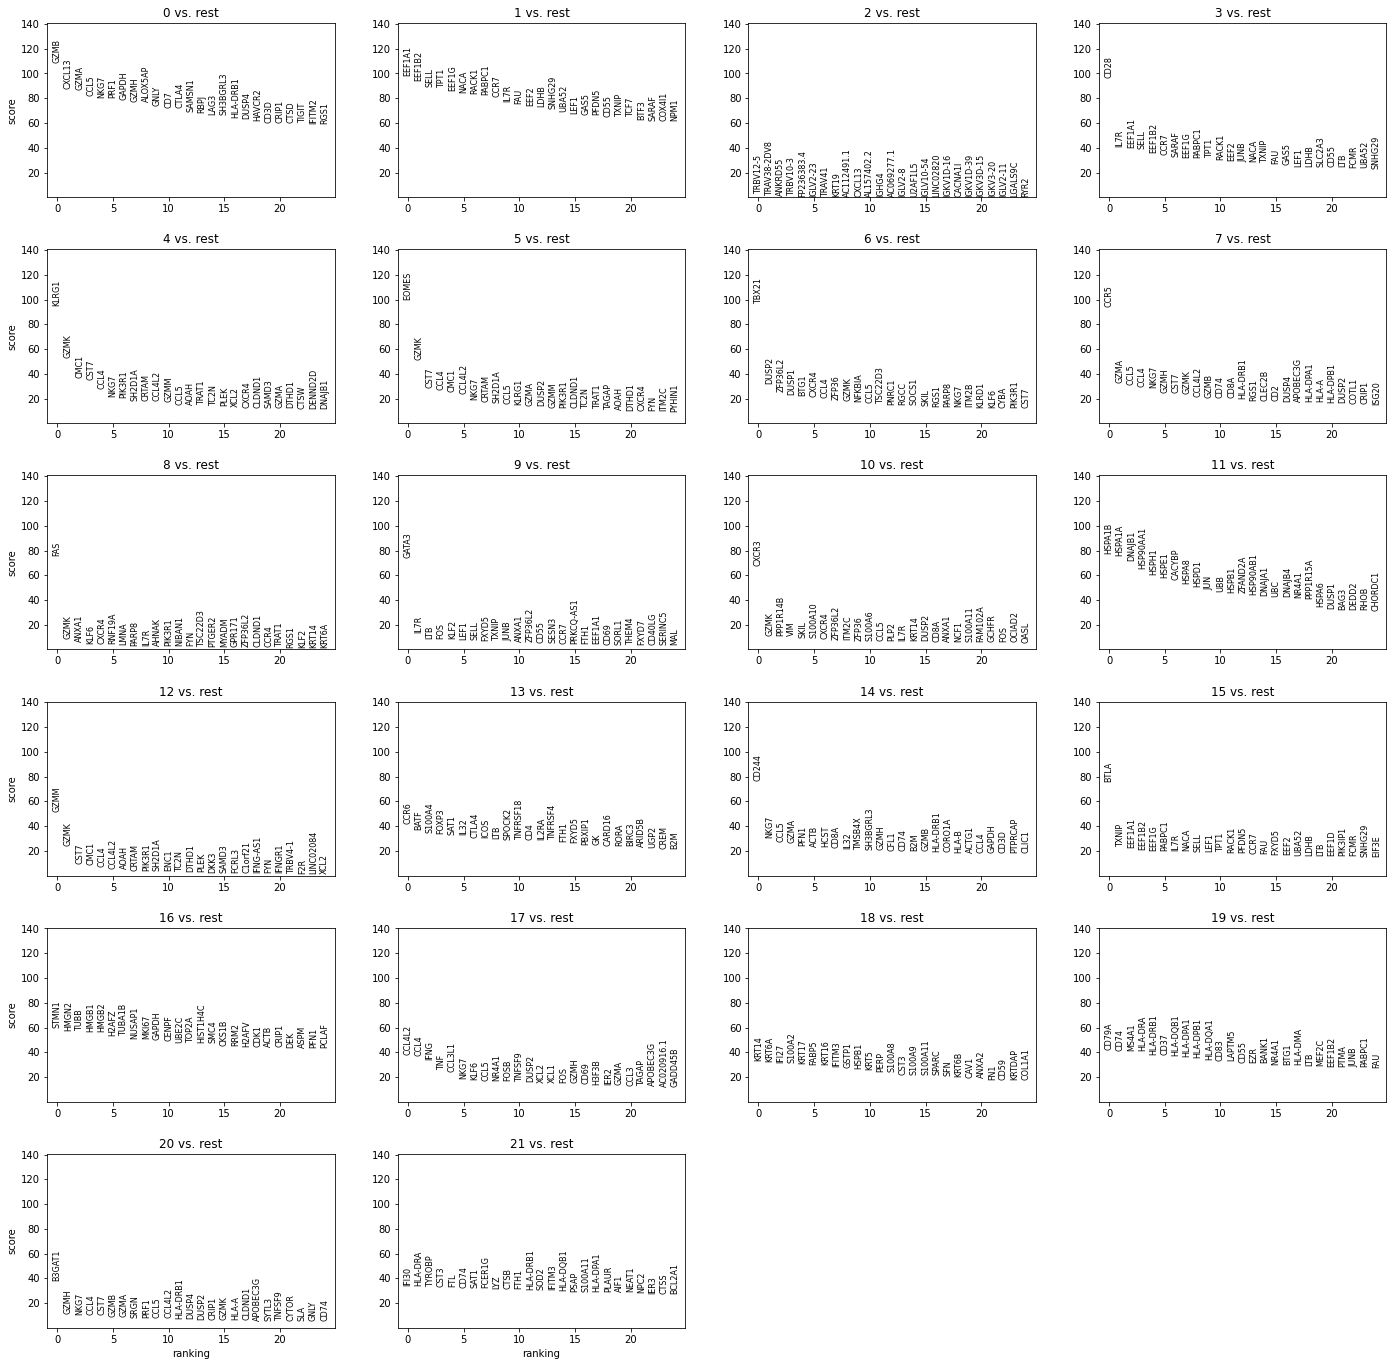

In [85]:
# find marker genes
sc.tl.rank_genes_groups(batch_corrected_umap, groupby='leiden',method='wilcoxon',use_faw=True)
sc.pl.rank_genes_groups(batch_corrected_umap,n_genes=25,use_raw=True)

In [86]:
!rm -f /scratch/cluster_genes_all.csv

In [87]:
cluster_marker_gene_file = '/scratch/cluster_genes_all.csv'
cluster_sizes = []
for i in range(len(set(batch_corrected_umap.obs['leiden']))):
    cluster_sizes.append(sum(batch_corrected_umap.obs['leiden']==str(i)))
    with open(cluster_marker_gene_file, 'a') as file:
        file_writer = csv.writer(file)
        file_writer.writerow(['Cluster'+str(i)+':',cluster_sizes[-1]])
        file_writer.writerow(batch_corrected_umap.uns['rank_genes_groups']['names'][str(i)][:30])
        file_writer.writerow(batch_corrected_umap.uns['rank_genes_groups']['logfoldchanges'][str(i)][:30])

## Cluster Annotation

In [ ]:
cluster_number = deepcopy(batch_corrected_umap.obs['leiden'])

In [ ]:
# annotate the cells along trajectory
cluster_annotations = ['(naive T)_1', '(naive T)_2', '(memory T)_1','activated CTL', 'Tfh', '(memory T)_3',
                       '(B)_1','late-dysfunctional T', 'highly activated CTL', 'early-mid activated T','pre-dysfunctional CTL',
                       '(naive T)_3','early activated CD8','(memory T)_2','mixed population','Treg',
                       'transitional cells', 'proliferating T','activated T','(B)_2','epithelial','myeloid',
                       'senescent T']

In [ ]:
# we duplicate the cluster numbering for easy exportation to TSCAN
batch_corrected_umap.obs['leiden_number'] = cluster_number
# annotate the clusters by renaming the leiden clusters
batch_corrected_umap.rename_categories('leiden', cluster_annotations)

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
sc.pl.umap(batch_corrected_umap, color='leiden', title='All Cell Clusters', legend_loc='on data',frameon=False,ax=ax)

In [ ]:
save_file = '/scratch/annotated_umap.h5ad'
batch_corrected_umap.write_h5ad(save_file)

# Exporting PCA and UMAP Represented Data Matrix

In [ ]:
batch_corrected_umap = sc.read('/scratch/annotated_umap.h5ad')

In [ ]:
for i, cluster in enumerate(cluster_annotations):
    print((i, cluster))

### Exporting data for clusters along CTL trajectory 

In [ ]:
# defining the trajectory of interest
selected_CTL_cluster_num = [0,7,9,10,11,12,18]
CTL_trajectory = [cluster_annotations[i] for i in selected_CTL_cluster_num]

# subsetting cells
CTL_trajectory_cells = batch_corrected_umap.obs['leiden']==CTL_trajectory[0]
for cluster in trajectory:
    CTL_trajectory_cells += (batch_corrected_umap.obs['leiden']==cluster)
CTL_trajectory_cells = batch_corrected_umap[CTL_trajectory_cells,:]

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))
sc.pl.umap(CTL_trajectory_cells, color='leiden', title='Effector T cells Clusters', legend_loc='on data',frameon=False,ax=ax)
plt.show()

In [ ]:
save_file = '/scratch/annotated_CTL_trajectory_umap.h5ad'
CTL_trajectory_cells.write_h5ad(save_file)

#### Extract the PCA representation for cells along the trajectory

In [ ]:
!rm -f /scratch/CTL_PCA_coordinates.csv

In [ ]:
# extract PCA coordinates from the scanpy data object and make cells into columns and coordinates into rows
PCA_coordinates = pd.DataFrame(trajectory_cells.obsm['X_pca'].T)
# change the coordinate names into PC_k
PCA_coordinates.index = ['PC_'+str(i) for i in range(1,len(PCA_coordinates.index)+1)]
# change cell names into cell_i
PCA_coordinates.columns = trajectory_cells.obs.index
# extract umap cluster assignment for each cell and make into a dataframe
umap_cluster = trajectory_cells.obs['leiden_number'].T.tolist()
umap_cluster = pd.DataFrame([umap_cluster],columns=PCA_coordinates.columns)
umap_cluster.index = ['cluster']
# merge umap assignment into PCA data frame
PCA_coordinates = PCA_coordinates.append(umap_cluster)

PCA_coordinates.to_csv('/scratch/CTL_PCA_coordinates.csv')

#### Extract cluster from specific trajectories

In [ ]:
!rm -f /scratch/CTL_UMAP_coordinates.csv

In [ ]:
# extract UMAP coordinates for cells
UMAP_coordinates = pd.DataFrame(CTL_trajectory_cells.obsm['X_umap'])
# give the two dimensions a name
UMAP_coordinates.columns = ['UMAP_'+str(i) for i in range(len(UMAP_coordinates.columns))]
# annotate cells with their UMAP cluster assignment
UMAP_coordinates['cluster'] = CTL_trajectory_cells.obs['leiden_number'].tolist()
# index the coordinates by the cell labels
UMAP_coordinates.index = CTL_trajectory_cells.obs.index
UMAP_coordinates = UMAP_coordinates.transpose()

UMAP_coordinates.to_csv('/scratch/CTL_UMAP_coordinates.csv')

## Alternatively using CellBrowser to export expression and UMAP data

In [ ]:
!rm -f /scratch/CTL_trajectory_expression_data
sc.external.exporting.cellbrowser(CTL_trajectory_cells, annot_keys=('leiden','percent_mito', 'n_genes', 'n_counts'), 
                                  data_dir='/scratch/CTL_trajectory_expression_data',data_name='trajectory_cells')
!gunzip /scratch/CTL_trajectory_expression_data/exprMatrix.tsv.gz

In [ ]:
# make sure that the expression matrix has been created and can be accessed
expression_data = pd.read_csv('/scratch/CTL_trajectory_expression_data/exprMatrix.tsv',sep='\t', index_col=0)

### Exporting data for clusters along memory trajectory 

In [ ]:
# defining the trajectory of interest
selected_memory_cluster_num = [1,3,9,18,2,5]
memory_trajectory = [cluster_annotations[i] for i in selected_memory_cluster_num]

# subsetting cells
memory_trajectory_cells = batch_corrected_umap.obs['leiden']==memory_trajectory[0]
for cluster in memory_trajectory:
    memory_trajectory_cells += (batch_corrected_umap.obs['leiden']==cluster)
memory_trajectory_cells = batch_corrected_umap[memory_trajectory_cells,:]

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sc.pl.umap(memory_trajectory_cells, color='leiden', title='Memory T cells Clusters', legend_loc='on data',frameon=False,ax=ax)
plt.show()

In [ ]:
save_file = '/scratch/annotated_memory_trajectory_umap.h5ad'
memory_trajectory_cells.write_h5ad(save_file)

In [ ]:
!rm -f /scratch/memory_UMAP_coordinates.csv
# extract UMAP coordinates for cells
UMAP_coordinates = pd.DataFrame(memory_trajectory_cells.obsm['X_umap'])
# give the two dimensions a name
UMAP_coordinates.columns = ['UMAP_'+str(i) for i in range(len(UMAP_coordinates.columns))]
# annotate cells with their UMAP cluster assignment
UMAP_coordinates['cluster'] = memory_trajectory_cells.obs['leiden_number'].tolist()
# index the coordinates by the cell labels
UMAP_coordinates.index = memory_trajectory_cells.obs.index
UMAP_coordinates = UMAP_coordinates.transpose()

UMAP_coordinates.to_csv('/scratch/memory_UMAP_coordinates.csv')

In [ ]:
!rm -rf /scratch/memory_trajectory_expression_data
sc.external.exporting.cellbrowser(memory_trajectory_cells, annot_keys=('leiden','percent_mito', 'n_genes', 'n_counts'), 
                                  data_dir='/scratch/memory_trajectory_expression_data',data_name='trajectory_cells')
!gunzip /scratch/memory_trajectory_expression_data/exprMatrix.tsv.gz

# make sure that the expression matrix has been created and can be accessed
expression_data = pd.read_csv('/scratch/memory_trajectory_expression_data/exprMatrix.tsv',sep='\t', index_col=0)

In [ ]:
expression_data

In [ ]:
set(UMAP_coordinates.loc['cluster'])